In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c elo-merchant-category-recommendation

 97% 597M/615M [00:04<00:00, 216MB/s]
100% 615M/615M [00:04<00:00, 156MB/s]


In [ ]:
! unzip elo-merchant-category-recommendation

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


###**1. Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency,chisquare
from pandas.plotting import scatter_matrix
import plotly.graph_objs as go
import plotly.offline as py
from datetime import datetime, date
import gc
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, Ridge
import pickle
import prettytable
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime
import datetime as dt
from datetime import datetime
# metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
import lightgbm as lgb
#Folds
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
from bayes_opt import BayesianOptimization
#cross_validations
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
#Modules for processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

###**2.Loading Datasets**

In [4]:
def reduce_mem_usage(data_frame,verbose=True):
  numerals=['int16','int32','int64','float16','float32','float64']# Here we define the datatypes numerals.
  initial_memory_usage=data_frame.memory_usage().sum()/ 1024**2# here we first calculate the memory usage by each feature and then sum up all the memory usage of all features in dataframe. Then we divide it by 2 power 12. So that memory usage will decrease by the dataframe.
  for k in data_frame.columns:#for each column in each dataframe
    datatype_feature= data_frame[k].dtypes# Here we found out the datatypes of each feature in dataframe.
    if datatype_feature in numerals:# Here we check the feature lies in the category of numerics feature.
      minimum_feature_value= data_frame[k].min()# if the feature is in numerics then first we get the  minimum of that feature.
      maximum_feature_value= data_frame[k].max()# if the feature is in numerics then first we get the  maximum of that feature.
      if str(datatype_feature)[:3]== 'int':#  Here we check that third feature is integer feature or not.
        if minimum_feature_value > np.iinfo(np.int8).min and maximum_feature_value < np.iinfo(np.int8).max:# IF integer values is in the between of c_min and c_max and have the value of int8.means of (-128 to 127).
          data_frame[k]= data_frame[k].astype(np.int8)# here simple we assign the int8 value in his corresponding integer value feature.
        elif minimum_feature_value > np.iinfo(np.int16).min and maximum_feature_value < np.iinfo(np.int16).max:# Here simple we check for the int16 means(-32,768 to 32,767) bit range.
          data_frame[k]= data_frame[k].astype(np.int16)# Here we assign the int16 values.  
        elif minimum_feature_value > np.iinfo(np.int32).min and maximum_feature_value < np.iinfo(np.int32).max:# Here for int32 means(-2,147,483,648 to 2,147,483,647) bit range.
          data_frame[k]= data_frame[k].astype(np.int32)#  Here we assign the int32 values.
        elif minimum_feature_value > np.iinfo(np.int64).min and maximum_feature_value < np.iinfo(np.int64).max:# here we assign the int64 means(-9,223,372,036,854,775,808 to 9,223,372,036,854,775,807) bit range.
          data_frame[k]= data_frame[k].astype(np.int64)# Here we assign the int64 values.
      else:  
        if minimum_feature_value > np.finfo(np.float16).min and maximum_feature_value < np.finfo(np.float16).max:# Otherwise if it is the float16 values range
          data_frame[k]= data_frame[k].astype(np.float16)# assign it corresponding values.
        elif minimum_feature_value > np.finfo(np.float32).min and maximum_feature_value < np.finfo(np.float32).max:# Here we check the min and max range of float 32 values.
          data_frame[k]= data_frame[k].astype(np.float32)# assign the corresponding values.
        else:
          data_frame[k] = data_frame[k].astype(np.float64)# similarly for int64. 
  final_memory_usage= data_frame.memory_usage().sum()/1024**2# Here we again decrease the memory usage of each feature after separating the corresponding bit integer and float values
  if verbose:
    print(' The  decrease in memory usage from {:5.2f}MB to ({:.1f}% reduction)'.format(final_memory_usage,100* (initial_memory_usage-final_memory_usage)/initial_memory_usage))# Here we find out the difference between the memory decrease from the starting and end memory usage.
  return data_frame

In [ ]:
%%time
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

CPU times: user 237 ms, sys: 52.7 ms, total: 290 ms
Wall time: 288 ms


In [ ]:
%%time
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv'))
historical_transactions = reduce_mem_usage(pd.read_csv('/content/historical_transactions.csv'))
new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv'))
gc.collect()

 The  decrease in memory usage from 30.32MB to (46.0% reduction)
 The  decrease in memory usage from 1749.11MB to (43.7% reduction)
 The  decrease in memory usage from 114.20MB to (45.5% reduction)
CPU times: user 42.2 s, sys: 14 s, total: 56.2 s
Wall time: 56.2 s


0

In [ ]:
historical_transactions = pd.read_csv('historical_transactions.csv')# read historical transaction files
historical_transactions=reduce_mem_usage(historical_transactions)# reduce the memory usage of historical transaction
historical_transactions.replace([-np.inf,np.inf],np.nan,inplace=True)# replace the -inf,inf to nan values
new_transactions = pd.read_csv('new_merchant_transactions.csv')# read the new merchants transactions files
new_transactions=reduce_mem_usage(new_transactions)# reduce the memory usage of new merchants transactions files
new_transactions.replace([-np.inf,np.inf],np.nan,inplace=True)# replace -inf,inf with nan values in new merchants files.
merchants=pd.read_csv('/content/merchants.csv')# read the merchants files
merchants=reduce_mem_usage(merchants)# reduce the memory usage of merchants files
merchants.replace([-np.inf,np.inf],np.nan,inplace=True)# replace the -inf, inf with nan in merchants files.

 The  decrease in memory usage from 1749.11MB to (43.7% reduction)
 The  decrease in memory usage from 114.20MB to (45.5% reduction)
 The  decrease in memory usage from 30.32MB to (46.0% reduction)


In [ ]:
historical_transactions['category_2'] = historical_transactions['category_2'].fillna(1,inplace=True)
historical_transactions['category_3'] = historical_transactions['category_3'].fillna('A',inplace=True)
historical_transactions['merchant_id'] = historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
historical_transactions['installments'].replace(-1, np.nan,inplace=True)
historical_transactions['installments'].replace(999, np.nan,inplace=True)
historical_transactions['purchase_amount'] = historical_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

In [ ]:
new_transactions['category_2'] = new_transactions['category_2'].fillna(1,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_transactions['installments'].replace(-1, np.nan,inplace=True)
new_transactions['installments'].replace(999, np.nan,inplace=True)
new_transactions['purchase_amount'] = new_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

###**2. Data Pre-processing**

**2.1 Imputing and Replacing Missing Values and Drop Duplicates**

We will be checking the Missing values and Duplicates and fixing them.
Also we will check the infinite values if present in any of our 5 datasets.

**2.2 Train Data**

In [ ]:
# finding duplicate rows count
duplicate_rows = len(train[train.duplicated()])
print('Number of duplicate rows =', duplicate_rows)

print('='*60)
# finding number of infinite values for each features
for i in train.columns:
  if i == 'first_active_month':
    continue
  inf_values = train[i].isin([np.inf, -np.inf]).sum()
  print('Number of infinite values in {} = {}'.format(i, inf_values))

print('='*60)
# finding missing values for each features
for i in train.columns:
  missing_values = train[i].isnull().sum()
  print('Number of missing values in {} = {}'.format(i, missing_values))

Number of duplicate rows = 0
Number of infinite values in card_id = 0
Number of infinite values in feature_1 = 0
Number of infinite values in feature_2 = 0
Number of infinite values in feature_3 = 0
Number of infinite values in target = 0
Number of missing values in first_active_month = 0
Number of missing values in card_id = 0
Number of missing values in feature_1 = 0
Number of missing values in feature_2 = 0
Number of missing values in feature_3 = 0
Number of missing values in target = 0


1. We do not have any duplicate values in train.
2. We do not have any missing values

**2.3 Test Data**

In [ ]:
# finding duplicate rows count
duplicate_rows = len(test[test.duplicated()])
print('Number of duplicate rows =', duplicate_rows)

print('='*60)
# finding inf and -inf values present in dataset
for i in test.columns:
  if i == 'first_active_month':
    continue
  inf_values = test[i].isin([np.inf, -np.inf]).sum()
  print('Number of infinite values in {} = {}'.format(i, inf_values))

print('='*60)
# finding missing values in each columns
for i in test.columns:
  missing_values = test[i].isnull().sum()
  print('Number of missing values in {} = {}'.format(i, missing_values))

Number of duplicate rows = 0
Number of infinite values in card_id = 0
Number of infinite values in feature_1 = 0
Number of infinite values in feature_2 = 0
Number of infinite values in feature_3 = 0
Number of missing values in first_active_month = 1
Number of missing values in card_id = 0
Number of missing values in feature_1 = 0
Number of missing values in feature_2 = 0
Number of missing values in feature_3 = 0


No Duplicates but the First Active Month has only one missing value.

In [ ]:
# missing value imputation using max count value
max_date = test['first_active_month'].value_counts().idxmax().date().strftime('%Y-%m-%d')
test['first_active_month'].fillna(max_date, inplace=True)
print('All missing value imputed')

All missing value imputed


**2.4 Merchant Data**

In [ ]:
# finding duplicate rows count
duplicate_rows = len(merchants[merchants.duplicated()])
print('Number of duplicate rows =', duplicate_rows)

print('='*60)
# finding number of infinite values for each features
for i in merchants.columns:
  inf_values = merchants[i].isin([np.inf, -np.inf]).sum()
  if inf_values > 0:
    print('Number of infinite values in {} = {}'.format(i, inf_values))

print('='*60)
# finding missing values in each columns
for i in merchants.columns:
  missing_values = merchants[i].isnull().sum()
  if missing_values > 0:
    print('Number of missing values in {} = {}'.format(i, missing_values))

Number of duplicate rows = 0
Number of infinite values in avg_purchases_lag3 = 3
Number of infinite values in avg_purchases_lag6 = 3
Number of infinite values in avg_purchases_lag12 = 3
Number of missing values in avg_sales_lag3 = 13
Number of missing values in avg_sales_lag6 = 13
Number of missing values in avg_sales_lag12 = 13
Number of missing values in category_2 = 11887


Missing values are present in average sales and category 2. 
There are few values with infinite values

In [ ]:
# replacement of inf and -inf values with nan value
merchants.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# missing value imputaion
merchants['avg_sales_lag3'].fillna(1, inplace=True)
merchants['avg_sales_lag6'].fillna(1, inplace=True)
merchants['avg_sales_lag12'].fillna(1, inplace=True)
merchants['avg_purchases_lag3'].fillna(1, inplace=True)
merchants['avg_purchases_lag6'].fillna(1, inplace=True)
merchants['avg_purchases_lag12'].fillna(1, inplace=True)
merchants['category_2'].fillna(1, inplace=True)

print('All missing value imputed!')

All missing value imputed!


In [ ]:
# categorical features encoding
merchants['category_1'].replace({'N':0, 'Y':1}, inplace=True)
merchants['category_4'].replace({'N':0, 'Y':1}, inplace=True)
merchants['most_recent_sales_range'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4}, inplace=True)
merchants['most_recent_purchases_range'].replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4}, inplace=True)

print('All categorical feature value encoded')

All categorical feature value encoded


**2.5 Historical Transactions**

In [ ]:
# finding duplicate rows count
duplicate_rows = len(historical_transactions[historical_transactions.duplicated()])
print('Number of duplicate rows =', duplicate_rows)

print('='*60)
# finding inf and -inf values in each of the features
for i in historical_transactions.columns:
  inf_values = historical_transactions[i].isin([np.inf, -np.inf]).sum()
  print('Number of infinite values in {} = {}'.format(i, inf_values))

print('='*60)
# finding missing values in each of the features
for i in historical_transactions.columns:
  missing_values = historical_transactions[i].isnull().sum()
  if missing_values > 0:
    print('Number of missing values in {} = {}'.format(i, missing_values))

Number of duplicate rows = 0
Number of infinite values in authorized_flag = 0
Number of infinite values in card_id = 0
Number of infinite values in city_id = 0
Number of infinite values in category_1 = 0
Number of infinite values in installments = 0
Number of infinite values in category_3 = 0
Number of infinite values in merchant_category_id = 0
Number of infinite values in merchant_id = 0
Number of infinite values in month_lag = 0
Number of infinite values in purchase_amount = 0
Number of infinite values in purchase_date = 0
Number of infinite values in category_2 = 0
Number of infinite values in state_id = 0
Number of infinite values in subsector_id = 0
Number of missing values in category_3 = 178159
Number of missing values in merchant_id = 138481
Number of missing values in category_2 = 2652864


There are lot of missing values in the historical data in three of the columns and we will impute them.

In [ ]:
historical_transactions['category_2'] = historical_transactions['category_2'].fillna(1,inplace=True)
historical_transactions['category_3'] = historical_transactions['category_3'].fillna('A',inplace=True)
historical_transactions['merchant_id'] = historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
historical_transactions['installments'].replace(-1, np.nan,inplace=True)
historical_transactions['installments'].replace(999, np.nan,inplace=True)
historical_transactions['purchase_amount'] = historical_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

print('All missing value imputed!')

All missing value imputed!


**2.6 New Merchant Transactions**

In [ ]:
# finding duplicate rows count
duplicate_rows = len(new_transactions[new_transactions.duplicated()])
print('Number of duplicate rows =', duplicate_rows)

print('='*60)
# removing the duplicate rows
new_transactions.drop_duplicates(inplace=True)
print('{} duplicate rows removed'.format(duplicate_rows))

print('='*60)
# finding the inf and -inf values in each columns
for i in new_transactions.columns:
  inf_values = new_transactions[i].isin([np.inf, -np.inf]).sum()
  print('Number of infinite values in {} = {}'.format(i, inf_values))

print('='*60)
# finding missing value in each column
for i in new_transactions.columns:
  missing_values = new_transactions[i].isnull().sum()
  if missing_values > 0:
    print('Number of missing values in {} = {}'.format(i, missing_values))

Number of duplicate rows = 10
10 duplicate rows removed
Number of infinite values in authorized_flag = 0
Number of infinite values in card_id = 0
Number of infinite values in city_id = 0
Number of infinite values in category_1 = 0
Number of infinite values in installments = 0
Number of infinite values in category_3 = 0
Number of infinite values in merchant_category_id = 0
Number of infinite values in merchant_id = 0
Number of infinite values in month_lag = 0
Number of infinite values in purchase_amount = 0
Number of infinite values in purchase_date = 0
Number of infinite values in category_2 = 0
Number of infinite values in state_id = 0
Number of infinite values in subsector_id = 0
Number of missing values in category_3 = 55921
Number of missing values in merchant_id = 26216
Number of missing values in category_2 = 111744


There are lot of missing values and 10 duplicated rows that are dropped.

In [ ]:
new_transactions['category_2'] = new_transactions['category_2'].fillna(1,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_transactions['installments'].replace(-1, np.nan,inplace=True)
new_transactions['installments'].replace(999, np.nan,inplace=True)
new_transactions['purchase_amount'] = new_transactions['purchase_amount'].apply(lambda x: min(x, 0.8))

print('All missing value imputed')

All missing value imputed


In [ ]:
train.to_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_train.csv', index=False)
test.to_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_test.csv', index=False)
merchants.to_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_merchants.csv', index=False)
historical_transactions.to_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_historical_transactions.csv', index=False)
new_transactions.to_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_new_transactions.csv', index=False)

###**3. Feature Engineering**

In [ ]:
%time
train = pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_test.csv', parse_dates=['first_active_month'])
merchants = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_merchants.csv'))
historical_transactions = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_historical_transactions.csv'))
new_transactions = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/pp_new_transactions.csv'))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Mem. usage decreased to 15.64 Mb (72.2% reduction)
Mem. usage decreased to 1166.08 Mb (62.5% reduction)
Mem. usage decreased to 74.88 Mb (64.3% reduction)


**3.1 Train Data**

In [ ]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()
# Here we are doing mean encoding for features with outliers
for k in ['feature_1','feature_2','feature_3']:
  label = train.groupby([k])['outliers'].mean()
  train[k+"_mean"] = train[k].map(label) 
# Now extract the days and Qtr
sr = pd.Series(train['first_active_month'])# Convert the first active month in series format
sr=pd.to_datetime(sr)
train['days'] = (date(2018, 2,1) - sr.dt.date).dt.days# just having error so we first try the numeric method
train['quarter'] = sr.dt.quarter# here we get the quarter.
k_cols = ['feature_1', 'feature_2', 'feature_3']
for i in k_cols:
  train['days_' + i] = train['days'] * train[i]
  train['days_' + i + '_ratio'] = train[i] / train['days']
gc.collect()

17

**3.2 Test Data**

In [ ]:
# Here we are doing mean encoding for features with outliers
for k in ['feature_1','feature_2','feature_3']:
  label = train.groupby([k])['outliers'].mean()
  test[k+"_mean"] = test[k].map(label) 
# Now extract the days and Qtr
sr = pd.Series(test['first_active_month']) # Convert the first active month in series format
sr=pd.to_datetime(sr)
test['days'] = (date(2018, 2,1) - sr.dt.date).dt.days #just having error so we first try the numeric method
test['quarter'] = sr.dt.quarter# here we get the quarter.
k_cols = ['feature_1', 'feature_2', 'feature_3']
for i in k_cols:
  test['days_' + i] = test['days'] * test[i]
  test['days_' + i + '_ratio'] = test[i] / test['days']
gc.collect()

17

Function to get remaining features

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

**3.3 Historical Transactions**

In [ ]:
# Additional features 
# https://www.kaggle.com/code/chauhuynh/my-first-kernel-3-699/notebook
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y': 1, 'N': 0})
historical_transactions['category_3'] = historical_transactions['category_3'].map({'A':0, 'B':1, 'C':2})
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])
historical_transactions['weekofyear'] = historical_transactions['purchase_date'].dt.weekofyear
historical_transactions['month'] = historical_transactions['purchase_date'].dt.month  # get the month
historical_transactions['day'] = historical_transactions['purchase_date'].dt.day  # get the day
historical_transactions['weekday'] = historical_transactions.purchase_date.dt.weekday # get the week day
historical_transactions['weekend'] = (historical_transactions.purchase_date.dt.weekday >=5).astype(int)# weekend
historical_transactions['hour'] =historical_transactions['purchase_date'].dt.hour# hour from the purchase date 
historical_transactions['month_diff'] = ((datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']
historical_transactions['duration'] = historical_transactions['purchase_amount']*historical_transactions['month_diff']
historical_transactions['amount_month_ratio'] = historical_transactions['purchase_amount']/historical_transactions['month_diff']
historical_transactions['price'] = historical_transactions['purchase_amount'] / historical_transactions['installments']
gc.collect()

87

In [ ]:
aggs = {}# here we aggregate all the values of sum,min,max,mean,var,skew for all the features
aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff']=['max','min','mean','var','skew']
aggs['weekend'] = ['sum', 'mean']
aggs['weekday'] = ['sum', 'mean']
aggs['authorized_flag']= ['sum', 'mean']
aggs['category_1']= ['sum','mean', 'max','min']
aggs['card_id'] = ['size','count']
aggs['month']= ['nunique', 'mean', 'min', 'max']
aggs['hour']= ['nunique', 'mean', 'min', 'max']
aggs['weekofyear']= ['nunique', 'mean', 'min', 'max']
aggs['day']= ['nunique', 'mean', 'min', 'max']
aggs['subsector_id']= ['nunique']
aggs['merchant_id']= ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['price'] =['sum','mean','max','min','var']
aggs['duration'] = ['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']
# here we try to aggregate all the mean,max,min,sum into category_2, category_3.
for col in ['category_2','category_3']:
  historical_transactions[col+'_mean'] = historical_transactions.groupby(historical_transactions[col])['purchase_amount'].agg('mean')
  historical_transactions[col+'_max'] = historical_transactions.groupby(historical_transactions[col])['purchase_amount'].agg('max')
  historical_transactions[col+'_min'] = historical_transactions.groupby(historical_transactions[col])['purchase_amount'].agg('min')
  historical_transactions[col+'_sum'] = historical_transactions.groupby(historical_transactions[col])['purchase_amount'].agg('sum')
  aggs[col+'_mean'] = ['mean']
gc.collect()      
# here we groupby the features by card_id and have new features.
new_columns = get_new_columns('hist',aggs)
historical_transactions_group = historical_transactions.groupby(['card_id']).agg(aggs)
historical_transactions_group.columns = new_columns
historical_transactions_group.reset_index(drop=False,inplace=True)

In [ ]:
train = train.merge(historical_transactions_group,on='card_id',how='left')
test = test.merge(historical_transactions_group,on='card_id',how='left')
del historical_transactions_group;
gc.collect()

0

**3.4 New Transactions Data**

In [ ]:
# https://www.kaggle.com/code/chauhuynh/my-first-kernel-3-699/notebook
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})
new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2})
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month# get the month
new_transactions['day'] = new_transactions['purchase_date'].dt.day# get the day
new_transactions['weekday'] = new_transactions.purchase_date.dt.weekday# get the week day
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)# weekend
new_transactions['hour'] =new_transactions['purchase_date'].dt.hour# hour from the purchase date 
new_transactions['month_diff'] = ((datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']
new_transactions['duration'] = new_transactions['purchase_amount']*new_transactions['month_diff']
new_transactions['amount_month_ratio'] = new_transactions['purchase_amount']/new_transactions['month_diff']
new_transactions['price'] = new_transactions['purchase_amount'] / new_transactions['installments']
gc.collect()

35

In [ ]:
aggs = {}# here we aggregate all the values of sum,min,max,mean,var,skew for all the features
aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
aggs['installments'] = ['sum','max','mean','var','skew']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var','skew']
aggs['month_diff']=['max','min','mean','var','skew']
aggs['weekend'] = ['sum', 'mean']
aggs['weekday'] = ['sum', 'mean']
aggs['authorized_flag']= ['sum', 'mean']
aggs['category_1']= ['sum','mean', 'max','min']
aggs['card_id'] = ['size','count']
aggs['month']= ['nunique', 'mean', 'min', 'max']
aggs['hour']= ['nunique', 'mean', 'min', 'max']
aggs['weekofyear']= ['nunique', 'mean', 'min', 'max']
aggs['day']= ['nunique', 'mean', 'min', 'max']
aggs['subsector_id']= ['nunique']
aggs['merchant_id']= ['nunique']
aggs['merchant_category_id'] = ['nunique']
aggs['price'] =['sum','mean','max','min','var']
aggs['duration'] = ['mean','min','max','var','skew']
aggs['amount_month_ratio']=['mean','min','max','var','skew']
# here we try to aggregate all the mean,max,min,sum into category_2, category_3.
for col in ['category_2','category_3']:
  new_transactions[col+'_mean'] = new_transactions.groupby(new_transactions[col])['purchase_amount'].agg('mean')
  new_transactions[col+'_max'] = new_transactions.groupby(new_transactions[col])['purchase_amount'].agg('max')
  new_transactions[col+'_min'] = new_transactions.groupby(new_transactions[col])['purchase_amount'].agg('min')
  new_transactions[col+'_sum'] = new_transactions.groupby(new_transactions[col])['purchase_amount'].agg('sum')
  aggs[col+'_mean'] = ['mean']
gc.collect()      
# here we groupby the features by card_id and have new features.
new_columns = get_new_columns('new_hist',aggs)
new_transactions_group = new_transactions.groupby(['card_id']).agg(aggs)
new_transactions_group.columns = new_columns
new_transactions_group.reset_index(drop=False,inplace=True)
train = train.merge(new_transactions_group,on='card_id',how='left')
test = test.merge(new_transactions_group,on='card_id',how='left')
del new_transactions_group;
gc.collect()

0

Deleting unwanted nan columns

In [ ]:
train=train.drop(['hist_category_2_mean_mean','hist_category_3_mean_mean'],axis=1)
test=test.drop(['hist_category_2_mean_mean','hist_category_3_mean_mean'],axis=1)
train=train.drop(['new_hist_category_2_mean_mean','new_hist_category_3_mean_mean'],axis=1)
test=test.drop(['new_hist_category_2_mean_mean','new_hist_category_3_mean_mean'],axis=1)

**3.5 Mechants Data**

In [ ]:
def aggregation_merchants(merchants):
  second_mode=lambda x: Counter(x).most_common(1)[0][0]#Counting the most common element and take it as second mode.
  # here we aggregate all the features of merchants with most common element and groupby according to merchant id.
  group_merchants=merchants.groupby('merchant_id',as_index=False).agg({
        "merchant_group_id": second_mode,
        "merchant_category_id": second_mode,
        "subsector_id": second_mode,
        "numerical_1": "mean",
        "numerical_2": "mean",
        "category_1": second_mode,
        "most_recent_sales_range": second_mode,
        "most_recent_purchases_range": second_mode,
        "avg_sales_lag3": "mean",
        "avg_purchases_lag3": "mean",
        "active_months_lag3": second_mode,
        "avg_sales_lag6": "mean",
        "avg_purchases_lag6": "mean",
        "active_months_lag6": second_mode,
        "avg_sales_lag12": "mean",
        "avg_purchases_lag12": "mean",
        "active_months_lag12": second_mode,
        "category_4": second_mode,
        "city_id": second_mode,
        "state_id": second_mode,
        "category_2": second_mode
  })
  return group_merchants

**3.6 Additional Features**

In [ ]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (datetime.today() - train['hist_purchase_date_min']).dt.days
sr = pd.Series(train['first_active_month'])
sr=pd.to_datetime(sr)
train['hist_first_buy'] = (train['hist_purchase_date_min'] - sr).dt.days
train['hist_last_buy'] = (train['hist_purchase_date_max'] - sr).dt.days

# here we convert this features in integer format for training in historical data.
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
  train[feature] = train[feature].astype(np.int64) * 1e-9
  
# Additional features 
# https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending 
train['new_hist_purchase_date_max'] = pd.to_datetime(train['new_hist_purchase_date_max'])
train['new_hist_purchase_date_min'] = pd.to_datetime(train['new_hist_purchase_date_min'])
train['new_hist_purchase_date_diff'] = (train['new_hist_purchase_date_max'] - train['new_hist_purchase_date_min']).dt.days
train['new_hist_purchase_date_average'] = train['new_hist_purchase_date_diff']/train['new_hist_card_id_size']
train['new_hist_purchase_date_uptonow'] = (datetime.today() - train['new_hist_purchase_date_max']).dt.days
train['new_hist_purchase_date_uptomin'] = (datetime.today() - train['new_hist_purchase_date_min']).dt.days
sr = pd.Series(train['first_active_month'])
sr=pd.to_datetime(sr)
train['new_first_buy'] = (train['new_hist_purchase_date_min'] - sr).dt.days
train['new_last_buy'] = (train['new_hist_purchase_date_max'] - sr).dt.days
train['new_hist_purchase_date_max'] = pd.to_numeric(train['new_hist_purchase_date_max'], errors='coerce')
train['new_hist_purchase_date_min'] = pd.to_numeric(train['new_hist_purchase_date_min'], errors='coerce')
train = train.dropna(subset=['new_hist_purchase_date_max'])
train = train.dropna(subset=['new_hist_purchase_date_min'])
# here we convert this features in integer format for training in new historical data.
for feature in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
  train[feature] = train[feature].astype(np.int64) * 1e-9    
  gc.collect()
  
train['card_id_total'] = train['new_hist_card_id_size']+train['hist_card_id_size']
train['card_id_cnt_total'] = train['new_hist_card_id_count']+train['hist_card_id_count']
train['card_id_cnt_ratio'] = train['new_hist_card_id_count']/train['hist_card_id_count']
train['purchase_amount_total'] = train['new_hist_purchase_amount_sum']+train['hist_purchase_amount_sum']
train['purchase_amount_mean'] = train['new_hist_purchase_amount_mean']+train['hist_purchase_amount_mean']
train['purchase_amount_max'] = train['new_hist_purchase_amount_max']+train['hist_purchase_amount_max']
train['purchase_amount_min'] = train['new_hist_purchase_amount_min']+train['hist_purchase_amount_min']
train['purchase_amount_ratio'] = train['new_hist_purchase_amount_sum']/train['hist_purchase_amount_sum']
train['month_diff_mean'] = train['new_hist_month_diff_mean']+train['hist_month_diff_mean']
train['month_diff_ratio'] = train['new_hist_month_diff_mean']/train['hist_month_diff_mean']
train['month_lag_mean'] = train['new_hist_month_lag_mean']+train['hist_month_lag_mean']
train['month_lag_max'] = train['new_hist_month_lag_max']+train['hist_month_lag_max']
train['month_lag_min'] = train['new_hist_month_lag_min']+train['hist_month_lag_min']
train['category_1_mean'] = train['new_hist_category_1_mean']+train['hist_category_1_mean']
train['installments_total'] = train['new_hist_installments_sum']+train['hist_installments_sum']
train['installments_mean'] = train['new_hist_installments_mean']+train['hist_installments_mean']
train['installments_max'] = train['new_hist_installments_max']+train['hist_installments_max']
train['installments_ratio'] = train['new_hist_installments_sum']/train['hist_installments_sum']
train['price_total'] = train['purchase_amount_total'] / train['installments_total']
train['price_mean'] = train['purchase_amount_mean'] / train['installments_mean']
train['price_max'] =train['purchase_amount_max'] / train['installments_max']
train['duration_mean'] = train['new_hist_duration_mean']+train['hist_duration_mean']
train['duration_min'] = train['new_hist_duration_min']+train['hist_duration_min']
train['duration_max'] = train['new_hist_duration_max']+train['hist_duration_max']
train['amount_month_ratio_mean']=train['new_hist_amount_month_ratio_mean']+train['hist_amount_month_ratio_mean']
train['amount_month_ratio_min']=train['new_hist_amount_month_ratio_min']+train['hist_amount_month_ratio_min']
train['amount_month_ratio_max']=train['new_hist_amount_month_ratio_max']+train['hist_amount_month_ratio_max']
train['new_CLV'] = train['new_hist_card_id_count'] * train['new_hist_purchase_amount_sum'] / train['new_hist_month_diff_mean']
train['hist_CLV'] =train['hist_card_id_count'] * train['hist_purchase_amount_sum'] / train['hist_month_diff_mean']
train['CLV_ratio'] = train['new_CLV'] / train['hist_CLV']
gc.collect()

0

In [ ]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (datetime.today() - test['hist_purchase_date_min']).dt.days
sr = pd.Series(test['first_active_month'])
sr=pd.to_datetime(sr)
test['hist_first_buy'] = (test['hist_purchase_date_min'] - sr).dt.days
test['hist_last_buy'] = (test['hist_purchase_date_max'] - sr).dt.days
# here we convert this features in integer format for training in historical data.
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
  test[feature] = test[feature].astype(np.int64) * 1e-9
  
  
test['new_hist_purchase_date_max'] = pd.to_datetime(test['new_hist_purchase_date_max'])
test['new_hist_purchase_date_min'] = pd.to_datetime(test['new_hist_purchase_date_min'])
test['new_hist_purchase_date_diff'] = (test['new_hist_purchase_date_max'] - test['new_hist_purchase_date_min']).dt.days
test['new_hist_purchase_date_average'] = test['new_hist_purchase_date_diff']/test['new_hist_card_id_size']
test['new_hist_purchase_date_uptonow'] = (datetime.today() - test['new_hist_purchase_date_max']).dt.days
test['new_hist_purchase_date_uptomin'] = (datetime.today() - test['new_hist_purchase_date_min']).dt.days
sr = pd.Series(test['first_active_month'])
sr=pd.to_datetime(sr)
test['new_first_buy'] = (test['new_hist_purchase_date_min'] - sr).dt.days
test['new_last_buy'] = (test['new_hist_purchase_date_max'] - sr).dt.days
test['new_hist_purchase_date_max'] = pd.to_numeric(test['new_hist_purchase_date_max'], errors='coerce')
test['new_hist_purchase_date_min'] = pd.to_numeric(test['new_hist_purchase_date_min'], errors='coerce')
test = test.dropna(subset=['new_hist_purchase_date_max'])
test = test.dropna(subset=['new_hist_purchase_date_min'])
# here we convert this features in integer format for training in historical data.
for feature in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
  test[feature] = test[feature].astype(np.int64) * 1e-9    
  gc.collect()

# Additional features 
# https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending  
test['card_id_total'] = test['new_hist_card_id_size']+test['hist_card_id_size']
test['card_id_cnt_total'] = test['new_hist_card_id_count']+test['hist_card_id_count']
test['card_id_cnt_ratio'] = test['new_hist_card_id_count']/test['hist_card_id_count']
test['purchase_amount_total'] = test['new_hist_purchase_amount_sum']+test['hist_purchase_amount_sum']
test['purchase_amount_mean'] = test['new_hist_purchase_amount_mean']+test['hist_purchase_amount_mean']
test['purchase_amount_max'] = test['new_hist_purchase_amount_max']+test['hist_purchase_amount_max']
test['purchase_amount_min'] = test['new_hist_purchase_amount_min']+test['hist_purchase_amount_min']
test['purchase_amount_ratio'] = test['new_hist_purchase_amount_sum']/test['hist_purchase_amount_sum']
test['month_diff_mean'] = test['new_hist_month_diff_mean']+test['hist_month_diff_mean']
test['month_diff_ratio'] = test['new_hist_month_diff_mean']/test['hist_month_diff_mean']
test['month_lag_mean'] = test['new_hist_month_lag_mean']+test['hist_month_lag_mean']
test['month_lag_max'] = test['new_hist_month_lag_max']+test['hist_month_lag_max']
test['month_lag_min'] = test['new_hist_month_lag_min']+test['hist_month_lag_min']
test['category_1_mean'] = test['new_hist_category_1_mean']+test['hist_category_1_mean']
test['installments_total'] = test['new_hist_installments_sum']+test['hist_installments_sum']
test['installments_mean'] = test['new_hist_installments_mean']+test['hist_installments_mean']
test['installments_max'] = test['new_hist_installments_max']+test['hist_installments_max']
test['installments_ratio'] = test['new_hist_installments_sum']/test['hist_installments_sum']
test['price_total'] = test['purchase_amount_total'] / test['installments_total']
test['price_mean'] = test['purchase_amount_mean'] / test['installments_mean']
test['price_max'] =test['purchase_amount_max'] / test['installments_max']
test['duration_mean'] = test['new_hist_duration_mean']+test['hist_duration_mean']
test['duration_min'] = test['new_hist_duration_min']+test['hist_duration_min']
test['duration_max'] = test['new_hist_duration_max']+test['hist_duration_max']
test['amount_month_ratio_mean']=test['new_hist_amount_month_ratio_mean']+test['hist_amount_month_ratio_mean']
test['amount_month_ratio_min']=test['new_hist_amount_month_ratio_min']+test['hist_amount_month_ratio_min']
test['amount_month_ratio_max']=test['new_hist_amount_month_ratio_max']+test['hist_amount_month_ratio_max']
test['new_CLV'] = test['new_hist_card_id_count'] * test['new_hist_purchase_amount_sum'] / test['new_hist_month_diff_mean']
test['hist_CLV'] =test['hist_card_id_count'] * test['hist_purchase_amount_sum'] / test['hist_month_diff_mean']
test['CLV_ratio'] = test['new_CLV'] / test['hist_CLV']
gc.collect()

0

In [ ]:
# here we again aggregate the card_id because there are some dulplicate card_id.
# here we aggregate the mean in numerical features of new merchants.
def aggregation_transactions(transactions):
    second_mode = lambda x: Counter(x).most_common(1)[0][0]#Counting the most common element and take it as second mode.
    # here we aggregate all the features of merchants with most common element and groupby according to merchant id.
    group_transactions = transactions.groupby("card_id",as_index=False).agg({
        "authorized_flag": second_mode,
        "merchant_category_id": second_mode,
        "subsector_id": second_mode,
        "merchant_id":  second_mode,
        "category_1": second_mode,
        'month_lag': second_mode,
        "installments": second_mode,
        "purchase_amount": "mean",
        "city_id": second_mode,
        "state_id": second_mode,
        "category_2": second_mode,
        "purchase_date": second_mode
    })
    return group_transactions

In [ ]:
# function for encoding train and test data
#https://narender-reddy.medium.com/elo-merchant-category-recommendation-competition-on-kaggle-lightgbm-implementation-a-case-83b0912fa7f3
def encoding_train(train, transactions, merchants, suffix):
  transactions=aggregation_transactions(transactions)# here we pass the new transactions data into the function to aggregate the most common values.
  transactions.columns= [k+suffix if k not in ['card_id','merchant_id'] else k for k in transactions.columns]# here we try to get the colmns based on card_id and merchant_id.
  transactions_train=pd.merge(train['card_id'],transactions,on='card_id',how='left')
  del transactions
  # merge the transaction and merchant data.
  merchants = aggregation_merchants(merchants) #aggregate the merchant data.
  merchants.columns=[k+'_merchants'+suffix if k!='merchant_id' else k for k in merchants.columns]#
  merge_merchants_transactions= pd.merge(transactions_train,merchants,on='merchant_id',how='left')
  del merchants
  del transactions_train
  del merge_merchants_transactions['merchant_id']
  train_card_id= train['card_id'].unique()
  INDEX= merge_merchants_transactions['card_id'].isin(list(train_card_id))
  merge_merchants_transactions_unique=merge_merchants_transactions.loc[INDEX]
  merge_merchants_transactions_unique_label=merge_merchants_transactions_unique.merge(train[['card_id','target']],how='left',left_on='card_id',right_on='card_id')
  del merge_merchants_transactions_unique
  gc.collect()
  merge_merchants_transactions.fillna(-9999,inplace=True)
  # Add the suffix to the features to make new features so that we induct the values which we have from aggregation.
  encoding_train_features=['authorized_flag'+suffix, 'category_1'+suffix, 'month_lag'+suffix, 'installments'+suffix,'category_2'+suffix,
        'numerical_1_merchants'+suffix, 'category_1_merchants'+suffix, 'most_recent_sales_range_merchants'+suffix,
        'most_recent_purchases_range_merchants'+suffix, 'active_months_lag3_merchants'+suffix, 
        'active_months_lag6_merchants'+suffix, 'active_months_lag12_merchants'+suffix, 'category_4_merchants'+suffix,
        'category_2_merchants'+suffix]
  for i in  encoding_train_features:
    encoding= merge_merchants_transactions_unique_label.groupby(i).target.mean()
    merge_merchants_transactions[i+'_mean_encoded']= merge_merchants_transactions[i].map(encoding)
  del encoding
  gc.collect()
  return merge_merchants_transactions       

In [ ]:
# Function to encoding test data
#https://narender-reddy.medium.com/elo-merchant-category-recommendation-competition-on-kaggle-lightgbm-implementation-a-case-83b0912fa7f3
def encoding_test(test, transactions, merchants, suffix):
  transactions=aggregation_transactions(transactions)
  transactions.columns= [k+suffix if k not in ['card_id','merchant_id'] else k for k in transactions.columns]
  transactions_test=pd.merge(test['card_id'],transactions,on='card_id',how='left')
  del transactions
  # merge the transaction and merchant data.
  merchants = aggregation_merchants(merchants)
  merchants.columns=[k+'_merchants'+suffix if k!='merchant_id' else k for k in merchants.columns]#
  merge_merchants_transactions= pd.merge(transactions_test,merchants,on='merchant_id',how='left')
  del merchants
  del transactions_test
  del merge_merchants_transactions['merchant_id']
  merge_merchants_transactions.fillna(-9999,inplace=True)
  gc.collect()
  print(' The shape of merge_merchants_transactions is: ',merge_merchants_transactions.shape)
  return merge_merchants_transactions  

Mean Encoding on the train data

In [ ]:
print(' The data frame train shape is:',train.shape)
print(' Here we perform the mean encoding')

merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv',nrows=1000))
transactions.replace([-np.inf, np.inf], np.nan, inplace=True)
# Mean encoding on train data.
mean_encoding_train=encoding_train(train, transactions, merchants, suffix='_new')
train= pd.merge(train,mean_encoding_train,on='card_id',how='left')
del mean_encoding_train
print(' This is the shape of data after mean encoding is:',train.shape)

# mean encoding on merchants_historical_transactions.
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)# here we replace the -inf,inf to nan value in merchnat data.
data_frame_historical_transactions=reduce_mem_usage(pd.read_csv('/content/historical_transactions.csv',nrows=1000))
data_frame_historical_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# Mean encoding on historical_transactions
mean_encoding_hist=encoding_train(train, data_frame_historical_transactions, merchants, suffix='_hist')
print(' We also been done by the historical mean encoding')
train=pd.merge(train,mean_encoding_hist, on='card_id',how='left')
del mean_encoding_hist

 The data frame train shape is: (201917, 198)
 Here we perform the mean encoding
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 This is the shape of data after mean encoding is: (201917, 244)
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 We also been done by the historical mean encoding


Mean Encoding for test data

In [ ]:
print(' The data frame test shape is:',test.shape)
print(' Here we perform the mean encoding')

# load the merchant data.
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv',nrows=1000))
transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# Mean encoding on train data.
mean_encoding_test=encoding_test(test, transactions, merchants, suffix='_new')
test= pd.merge(test,mean_encoding_test,on='card_id',how='left')
del mean_encoding_test
print(' This is the shape of data after mean encoding is:',test.shape)

# mean encoding on merchants_historical_transactions.
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv',nrows=1000))
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)
data_frame_historical_transactions=reduce_mem_usage(pd.read_csv('/content/historical_transactions.csv',nrows=1000))
data_frame_historical_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

# Mean encoding on historical_transactions
mean_encoding_hist=encoding_test(test, data_frame_historical_transactions, merchants, suffix='_hist')
print(' We also been done by the historical mean encoding')
test=pd.merge(test,mean_encoding_hist,on='card_id',how='left')
del mean_encoding_hist

 The data frame test shape is: (123623, 196)
 Here we perform the mean encoding
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 The shape of merge_merchants_transactions is:  (123623, 33)
 This is the shape of data after mean encoding is: (123623, 228)
 The  decrease in memory usage from  0.09MB to (46.0% reduction)
 The  decrease in memory usage from  0.06MB to (46.4% reduction)
 The shape of merge_merchants_transactions is:  (123623, 33)
 We also been done by the historical mean encoding


In [ ]:
# checking for missing values after merging this new features with existing train and test set
print('------------------------Missing value in train set------------------------')
print(train.columns[train.isnull().any()])
print('='*80)
print('------------------------Missing value in test set------------------------')
print(test.columns[test.isnull().any()])

In [ ]:
# Ordering of variables correctly to the target variable
columns_of_train = ['authorized_flag_new', 'category_1_new', 'month_lag_new', 'installments_new','category_2_new',
          'numerical_1_merchants_new', 'category_1_merchants_new', 'most_recent_sales_range_merchants_new',
          'most_recent_purchases_range_merchants_new', 'active_months_lag3_merchants_new', 
          'active_months_lag6_merchants_new', 'active_months_lag12_merchants_new', 'category_4_merchants_new',
          'category_2_merchants_new', 
          'authorized_flag_hist', 'category_1_hist', 'month_lag_hist', 'installments_hist', 'category_2_hist',
          'numerical_1_merchants_hist', 'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
          'most_recent_purchases_range_merchants_hist', 'active_months_lag3_merchants_hist', 
          'active_months_lag6_merchants_hist', 'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
          'category_2_merchants_hist']
           
for i in columns_of_train:
  target_in_order = train.groupby([i])['target'].mean()# here we try to groupby the mean of target in train data so that this target map with test data.
  test[i+"_mean_encoded"] =  test[i].map(target_in_order)

Perform the one hot encoding for replacing the nan values

In [ ]:
# one hot encoding for train data.
for i in train.columns:
  if train[i].isna().any():
    train[i].replace([-np.inf, np.inf, np.nan], train[i].min(), inplace=True)
for i in test.columns:
  if test[i].isna().any():
    test[i].replace([-np.inf, np.inf, np.nan], test[i].dropna().min(), inplace=True)
train = pd.concat([train, pd.get_dummies(train[columns_of_train], prefix = 'ohe_').astype(np.int8)], axis=1)
test = pd.concat([test, pd.get_dummies(test[columns_of_train], prefix = 'ohe_').astype(np.int8)], axis=1)
print('Here we perform the one hot encoding on train and test data')
print('The dimension of train data are:',train.columns)
print('The dimension of test data are:',test.columns) 

Here we perform the one hot encoding on train and test data
The dimension of train data are: Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'outliers', 'feature_1_mean', 'feature_2_mean',
       'feature_3_mean',
       ...
       'category_4_merchants_hist', 'category_2_merchants_hist', 'ohe__-9999',
       'ohe__Y', 'ohe__-9999', 'ohe__N', 'ohe__-9999', 'ohe__Y', 'ohe__-9999',
       'ohe__N'],
      dtype='object', length=322)
The dimension of test data are: Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'feature_1_mean', 'feature_2_mean', 'feature_3_mean', 'days', 'quarter',
       ...
       'category_4_merchants_hist', 'category_2_merchants_hist', 'ohe__-9999',
       'ohe__Y', 'ohe__-9999', 'ohe__N', 'ohe__-9999', 'ohe__Y', 'ohe__-9999',
       'ohe__N'],
      dtype='object', length=320)


Check for duplicate column names

In [ ]:
# Assign the unique columns in train
columns_train=pd.Series(train.columns)
for k in columns_train[columns_train.duplicated()].unique():
  columns_train[columns_train[columns_train == k].index.values.tolist()] = [k + '_' + str(i) if i != 0 else k for i in range(sum(columns_train == k))]
train.columns=columns_train

# Assign the unique columns in test.
columns_test=pd.Series(test.columns)
for k in columns_test[columns_test.duplicated()].unique():
  columns_test[columns_test[columns_test == k].index.values.tolist()] = [k + '_' + str(i) if i != 0 else k for i in range(sum(columns_test == k))]
test.columns=columns_test

Delete the basic columns

In [ ]:
columns_delete = ['feature_1','feature_2','feature_3', 'authorized_flag_new', 'merchant_category_id_new',
       'subsector_id_new', 'category_1_new', 'month_lag_new',
       'installments_new', 'purchase_amount_new', 'city_id_new',
       'state_id_new', 'category_2_new', 'purchase_date_new',
       'merchant_group_id_merchants_new', 'merchant_category_id_merchants_new',
       'subsector_id_merchants_new', 'numerical_1_merchants_new',
       'numerical_2_merchants_new', 'category_1_merchants_new',
       'most_recent_sales_range_merchants_new',
       'most_recent_purchases_range_merchants_new',
       'avg_sales_lag3_merchants_new', 'avg_purchases_lag3_merchants_new',
       'active_months_lag3_merchants_new', 'avg_sales_lag6_merchants_new',
       'avg_purchases_lag6_merchants_new', 'active_months_lag6_merchants_new',
       'avg_sales_lag12_merchants_new', 'avg_purchases_lag12_merchants_new',
       'active_months_lag12_merchants_new', 'category_4_merchants_new',
       'city_id_merchants_new', 'state_id_merchants_new',
       'category_2_merchants_new', 'authorized_flag_hist',
       'merchant_category_id_hist', 'subsector_id_hist', 'category_1_hist',
       'month_lag_hist', 'installments_hist', 'purchase_amount_hist',
       'city_id_hist', 'state_id_hist', 'category_2_hist',
       'purchase_date_hist', 'merchant_group_id_merchants_hist',
       'merchant_category_id_merchants_hist', 'subsector_id_merchants_hist',
       'numerical_1_merchants_hist', 'numerical_2_merchants_hist',
       'category_1_merchants_hist', 'most_recent_sales_range_merchants_hist',
       'most_recent_purchases_range_merchants_hist',
       'avg_sales_lag3_merchants_hist', 'avg_purchases_lag3_merchants_hist',
       'active_months_lag3_merchants_hist', 'avg_sales_lag6_merchants_hist',
       'avg_purchases_lag6_merchants_hist',
       'active_months_lag6_merchants_hist', 'avg_sales_lag12_merchants_hist',
       'avg_purchases_lag12_merchants_hist',
       'active_months_lag12_merchants_hist', 'category_4_merchants_hist',
       'city_id_merchants_hist', 'state_id_merchants_hist',
       'category_2_merchants_hist']
#Dropping the above columns       
test = test.drop(columns_delete, axis = 1)
train = train.drop(columns_delete, axis = 1)
train =  train.loc[:, train.columns[0:200]]
test =  test.loc[:, test.columns[0:200]]

In [ ]:
train.head()

,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,...,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
0,2017-06,C_ID_92a2005557,-0.820283,0,0.013145,0.008752,0.011428,245,2,1225,...,-0.026591,0.008997,-5.486313,-783.095153,0.007006,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
1,2017-01,C_ID_3d0044924f,0.392913,0,0.010712,0.011385,0.010283,396,1,1584,...,-0.026335,0.001756,-0.462528,-1333.091845,0.000347,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
2,2016-08,C_ID_d639edf6cd,0.688056,0,0.010610,0.008752,0.010283,549,3,1098,...,-0.026006,-0.015383,-0.012731,-22.669402,0.000562,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
3,2017-09,C_ID_186d6a6901,0.142495,0,0.010712,0.014166,0.010283,153,3,612,...,-0.026585,0.004422,-0.586335,-69.632709,0.008420,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
4,2017-11,C_ID_cdbd2c0db2,-0.159749,0,0.008058,0.014166,0.010283,92,4,92,...,-0.026939,0.022598,-12.905691,-180.258028,0.071596,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965


Check for outliers

In [ ]:
test_card_id = test['card_id']
print('The count of nan values is:', train.isna().any().sum())
# Assign 1 to the non-outlier value and 0 to outliers. 
correct_data_points = train.loc[train['outliers'] ==0]
outliers = train.loc[train['outliers'] ==1]
target = train['target']
outlier_card_ids = outliers['card_id']
card_id_correct_data_point = correct_data_points['card_id']
print('This is the correct data points:')
correct_data_points.head()

The count of nan values is: 0
This is the correct data points:


,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,...,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
0,2017-06,C_ID_92a2005557,-0.820283,0,0.013145,0.008752,0.011428,245,2,1225,...,-0.026591,0.008997,-5.486313,-783.095153,0.007006,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
1,2017-01,C_ID_3d0044924f,0.392913,0,0.010712,0.011385,0.010283,396,1,1584,...,-0.026335,0.001756,-0.462528,-1333.091845,0.000347,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
2,2016-08,C_ID_d639edf6cd,0.688056,0,0.010610,0.008752,0.010283,549,3,1098,...,-0.026006,-0.015383,-0.012731,-22.669402,0.000562,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
3,2017-09,C_ID_186d6a6901,0.142495,0,0.010712,0.014166,0.010283,153,3,612,...,-0.026585,0.004422,-0.586335,-69.632709,0.008420,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
4,2017-11,C_ID_cdbd2c0db2,-0.159749,0,0.008058,0.014166,0.010283,92,4,92,...,-0.026939,0.022598,-12.905691,-180.258028,0.071596,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965


In [ ]:
print('This is the outlier data points:')
outliers.head()

This is the outlier data points:


,first_active_month,card_id,target,outliers,feature_1_mean,feature_2_mean,feature_3_mean,days,quarter,days_feature_1,...,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,authorized_flag_new_mean_encoded,category_1_new_mean_encoded,month_lag_new_mean_encoded,installments_new_mean_encoded,category_2_new_mean_encoded
64,2017-09,C_ID_8186f3fcc1,-33.219281,1,0.010479,0.011385,0.011428,153,3,459,...,-0.026441,0.006520,-1.670814,-60.439204,0.027645,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
92,2015-05,C_ID_b9379a30ea,-33.219281,1,0.010479,0.014166,0.011428,1007,2,3021,...,-0.024906,-0.001746,-0.191009,-17.793865,0.010735,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
125,2015-10,C_ID_e9120f535c,-33.219281,1,0.010479,0.014166,0.011428,854,4,2562,...,-0.027163,-0.026784,-139.712383,-33.984137,-66793.249892,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
151,2017-03,C_ID_65715cb80d,-33.219281,1,0.010712,0.008752,0.010283,337,1,1348,...,-0.027163,-0.026784,-139.712383,-433.178256,-66793.249892,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965
225,2017-01,C_ID_ae77d244b6,-33.219281,1,0.010610,0.011385,0.010283,396,1,792,...,-0.026403,-0.014385,-0.090959,-38.625836,0.002355,-0.613542,-0.613542,-1.046168,-0.785954,-0.871965


Feature names of the train data just exclude some features

### **4. Model Building**

In [5]:
%time
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/train_FE2.csv'))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Python_Datasets/Case_study_1/test_FE2.csv'))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
 The  decrease in memory usage from 92.62MB to (69.9% reduction)
 The  decrease in memory usage from 55.06MB to (70.8% reduction)


**4.1 Train repeated k-fold with lgbm**

In [7]:
omit = ['first_active_month', 'target','merchant_id', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size', 'target_f']
data_frame_columns = [i for i in train.columns if i not in omit]
categorical_feats = [c for c in data_frame_columns if 'feature_' in c]

In [8]:
from sklearn.linear_model import BayesianRidge
number_of_folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
predictions_target = np.zeros(len(train))
predictions_target_test = np.zeros(len(test))
data_frame_feature_importance = pd.DataFrame()
dimensions = data_frame_columns

###**5. Hyperparameter Tuning**

In [9]:
def LGB_CV(max_depth,num_leaves,min_data_in_leaf, min_child_weight, min_split_gain, 
           subsample, top_rate, other_rate,colsample_bytree,reg_alpha,reg_lambda
         ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][data_frame_columns],
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][data_frame_columns],
                               label=target.iloc[val_idx])
    
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "bagging_seed": 11,
            "metric": 'rmse',
            'min_child_weight': min_child_weight,
            'min_split_gain': min_split_gain,
            'subsample': subsample,
            'top_rate': top_rate,
            'other_rate':other_rate,
            'colsample_bytree':colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(train.iloc[val_idx][data_frame_columns],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, target)**0.5

In [10]:
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 65),
    'min_data_in_leaf': (10, 30),
    'min_child_weight': (5, 60),
    'min_split_gain': (5, 15),
    'subsample': (0.8, 1),
    'top_rate': (0.9, 1),
    'other_rate': (0, 0.1),
    'colsample_bytree': (0, 0.99),
    'reg_alpha': (5, 15),
    'reg_lambda': (5, 15)
    })

In [11]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
print('-'*126)

start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)
timer(start_time)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... | max_depth | min_ch... | min_da... | min_sp... | num_le... | other_... | reg_alpha | reg_la... | subsample | top_rate  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63172	valid_1's rmse: 3.69426
[1000]	training's rmse: 3.59425	valid_1's rmse: 3.6834
[1500]	training's rmse: 3.56735	valid_1's rmse: 3.68069
[2000]	training's rmse: 3.54551	valid_1's rmse: 3.68013
Early stopping, best iteration is:
[1927]	training's rmse: 3.54851	valid_1's rmse: 3.68009
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64762	valid_1's rmse: 3.63392
[1000]	training's rmse: 3.61015	valid_1's rms

In [ ]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])


history_df = pd.DataFrame([x['params'] for x in LGB_BO.res])
history_df2 = pd.DataFrame([x['target'] for x in LGB_BO.res])
history_df = pd.concat((history_df, history_df2), axis=1)
history_df.rename(columns = { 0 : 'gini'}, inplace=True)
history_df.to_csv('ParametersOptimization.csv')

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: -3.653867
Best  parameters:  {'colsample_bytree': 0.40522959076413667, 'max_depth': 6.717733781648738, 'min_child_weight': 53.526503071616105, 'min_data_in_leaf': 14.149168225148243, 'min_split_gain': 5.7028895949632465, 'num_leaves': 18.65946164821559, 'other_rate': 0.01057827550408046, 'reg_alpha': 7.278830113413007, 'reg_lambda': 8.396856518162293, 'subsample': 0.9479136625258441, 'top_rate': 0.9881136070711608}


**5.1 Light GBM Modelling Technique with Repeated K Folds**

In [ ]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()
features = data_frame_columns
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[data_frame_columns].values, target.values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][data_frame_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][data_frame_columns], label=target.iloc[val_idx])
    
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9479136625258441,
                'max_depth': 7,
                'num_leaves': 19,
                'min_child_weight': 53.526503071616105,
                'top_rate': 0.9881136070711608,
                'other_rate': 0.01057827550408046,
                'colsample_bytree': 0.40522959076413667,
                'min_split_gain': 5.7028895949632465,
                'reg_alpha': 7.278830113413007,
                'reg_lambda': 8.396856518162293,
                'min_data_in_leaf': 14,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }

       
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][data_frame_columns], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = data_frame_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[data_frame_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2436]	training's rmse: 3.42647	valid_1's rmse: 3.66424
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2189]	training's rmse: 3.41113	valid_1's rmse: 3.79882
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1739]	training's rmse: 3.49563	valid_1's rmse: 3.56016
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1411]	training's rmse: 3.50289	valid_1's rmse: 3.62453
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2154]	training's rmse: 3.45279	valid_1's rmse: 3.61581
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2781]	training's rmse: 3.38629	valid_1's rmse: 3.73076
fold 6
Training until validation s

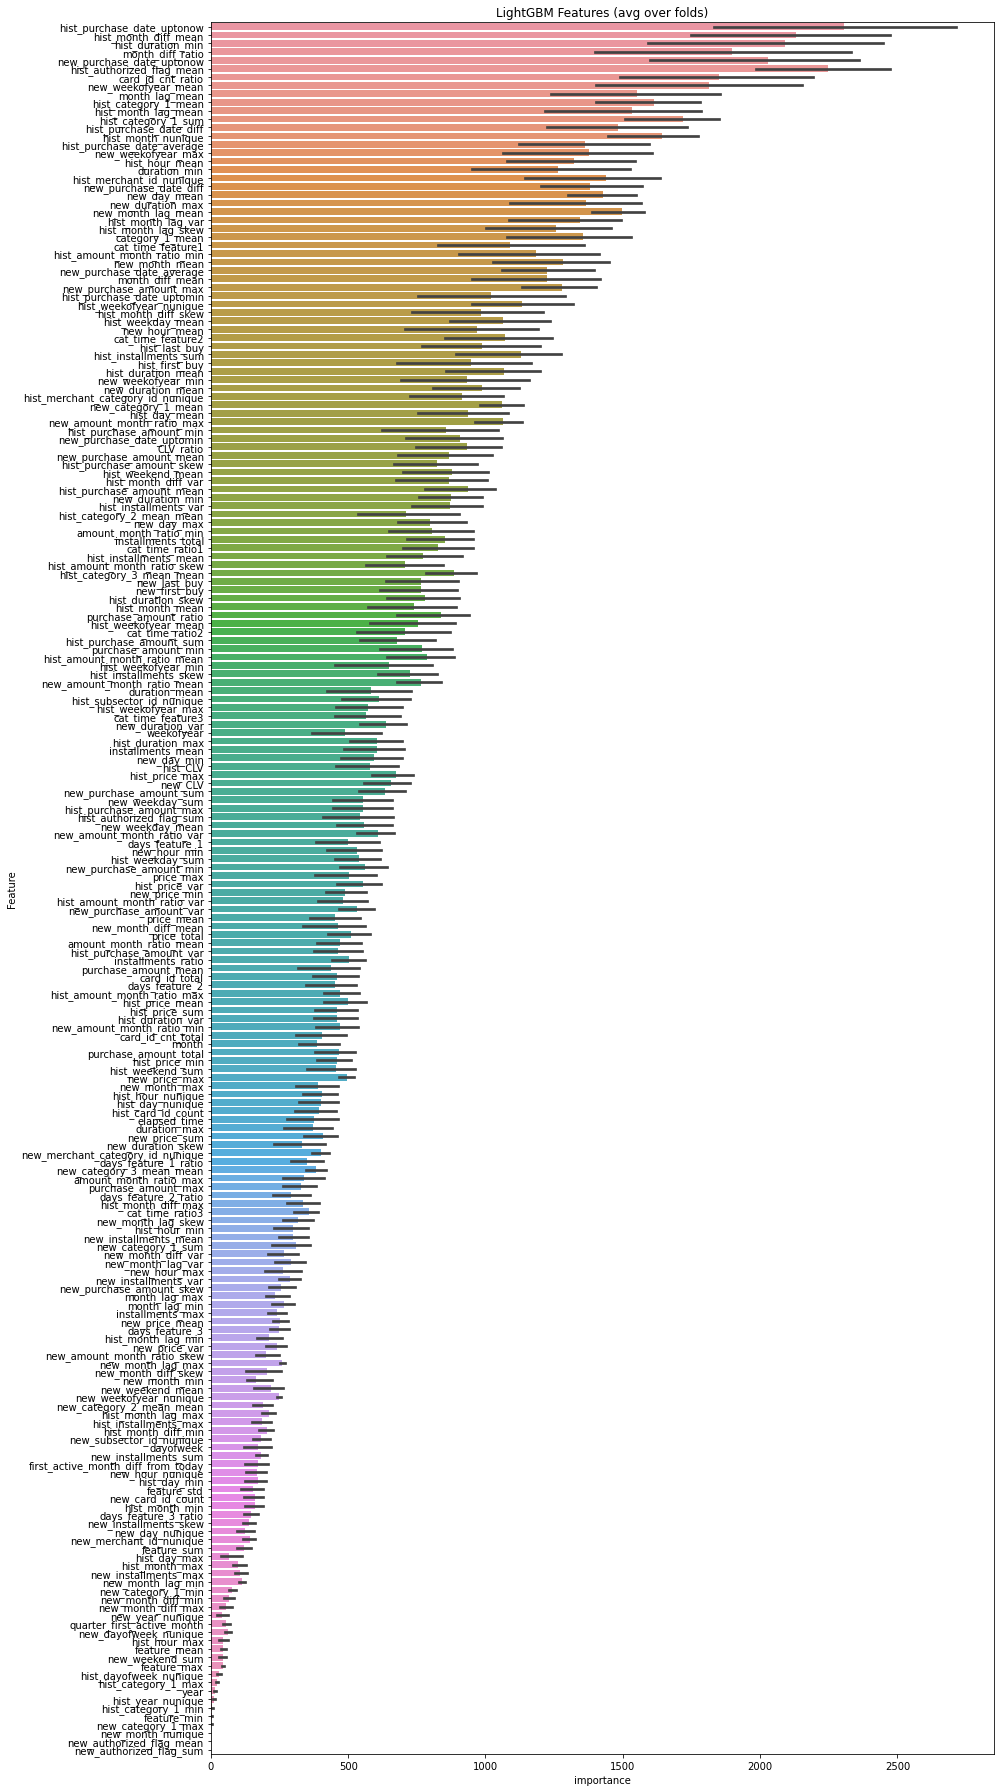

In [ ]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

**5.2 Light GBM Modelling Technique with Stratified K Folds**

In [ ]:
%%time
# Change in Hyper Parameters using kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
import lightgbm as lgb
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][data_frame_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][data_frame_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9479136625258441,
                'max_depth': 7,
                'num_leaves': 19,
                'min_child_weight': 53.526503071616105,
                'top_rate': 0.9881136070711608,
                'other_rate': 0.01057827550408046,
                'colsample_bytree': 0.40522959076413667,
                'min_split_gain': 5.7028895949632465,
                'reg_alpha': 7.278830113413007,
                'reg_lambda': 8.396856518162293,
                'min_data_in_leaf': 14,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                        }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][data_frame_columns ], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = data_frame_columns 
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[data_frame_columns], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2645]	training's rmse: 3.41781	valid_1's rmse: 3.65102
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2045]	training's rmse: 3.45669	valid_1's rmse: 3.64922
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1249]	training's rmse: 3.50387	valid_1's rmse: 3.66932
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2137]	training's rmse: 3.44944	valid_1's rmse: 3.64328
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2143]	training's rmse: 3.44572	valid_1's rmse: 3.6512
CV score: 3.65282 
CPU times: user 21min 40s, sys: 3.75 s, total: 21min 43s
Wall time: 5min 40s


3.652817711210018

**5.3 XgBoost**

In [ ]:
%%time
import xgboost as xgb
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4076)
oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))
feature_importance_df_3 = pd.DataFrame()

xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True,
    'booster': 'gbtree',
    'n_jobs': 4,
    'n_estimators': 20000,
    'grow_policy': 'lossguide',
    'max_depth': 12,
    'seed': 538,
    'colsample_bylevel': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0.0001,
    'learning_rate': 0.006150886706231842,
    'max_bin': 128,
    'max_leaves': 47,
    'min_child_weight': 40,
    'reg_alpha': 10.0,
    'reg_lambda': 10.0,
    'silent': True,
    'eta': 0.005,
    'subsample': 0.9
}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(outliers,outliers['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=outliers.iloc[trn_idx][data_frame_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=outliers.iloc[val_idx][data_frame_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=500, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][data_frame_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[data_frame_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / (5 * 2)

np.save('oof_xgb', oof_xgb_3)
np.save('predictions_xgb', predictions_xgb_3)
print(np.sqrt(mean_squared_error(target.values, oof_xgb_3)))

-
Fold 1
xgb 0--------------------------------------------------
[0]	train-rmse:3.96078	valid-rmse:3.91087
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[494]	train-rmse:3.71499	valid-rmse:3.81274

-
Fold 2
xgb 1--------------------------------------------------
[0]	train-rmse:3.92951	valid-rmse:4.03499
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[452]	train-rmse:3.73309	valid-rmse:3.93585

-
Fold 3
xgb 2--------------------------------------------------
[0]	train-rmse:3.93499	valid-rmse:4.01299
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[473]	train-rmse:3.71185	valid-rmse:3.90975

-
Fold 4
xgb 3--------------

**5.3 Stacking**

In [ ]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3 = clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6490788711713846

**Summary and Submission**

In [ ]:
submission_name = pd.to_datetime("today")
sub_df = pd.read_csv('/content/sample_submission.csv')
sub_df['target'] = predictions_3
sub_df.to_csv('/content/submission_102.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_102.csv' -m "final_sfold_ipnb"

100% 4.23M/4.23M [00:00<00:00, 16.8MB/s]
Successfully submitted to Elo Merchant Category Recommendation

In [12]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model', 'train_RMSE', 'test_RMSE']
x.add_row(["single LGBM model with repeated K-Folds", "3.46663", "3.59695"])
x.add_row(["single LGBM model with Stratified K-Folds", "3.44572", "3.6512"])
x.add_row(["XGB", "3.73105", "3.7928"])
print(x)

+-------------------------------------------+------------+-----------+
|                   Model                   | train_RMSE | test_RMSE |
+-------------------------------------------+------------+-----------+
|  single LGBM model with repeated K-Folds  |  3.46663   |  3.59695  |
| single LGBM model with Stratified K-Folds |  3.44572   |   3.6512  |
|                    XGB                    |  3.73105   |   3.7928  |
+-------------------------------------------+------------+-----------+


private score after Submission in kaggle


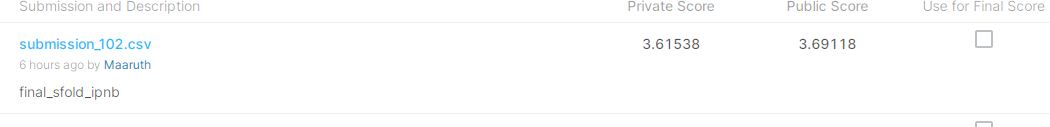

In [ ]:
from IPython.display import Image
print("private score after Submission in kaggle")
Image("/content/ps_score_hpt.JPG")

Score is in top 10% in kaggle leaderboard


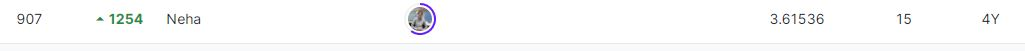

In [ ]:
from IPython.display import Image

print("Score is in top 10% in kaggle leaderboard")
Image("/content/lb_score_hpt.JPG")